# Сверточные нейронные сети в PyTorch

---

## Сверточная нейронная сеть классификации изображений

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

try:  
  from torchsummary import summary
except:
  !pip install -U torchsummary
  from torchsummary import summary

Рассмотрим задачу классификации для датасета Cifar10 - это классический датасет с изображениями, относящимися к 10 классам.
Каждое изображение трех-цветное и имеет размер 32 на 32 пикслея (то есть представляет тензор размером 3х32х32).

Например Cifar10 содержит следующие изображения.

![](https://debuggercafe.com/wp-content/uploads/2019/10/cifar10_plot.png)

Загрузим датасет и проведем его нормализацию

In [ ]:
transform =\
    transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize( 
                            mean = (0.5, 0.5, 0.5), 
                            std  = (0.5, 0.5, 0.5)  )
                       ])

BATCH_SIZE = 4

trainset = torchvision.datasets.CIFAR10(root      = './data', 
                                        train     = True,
                                        download  = True, 
                                        transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size = BATCH_SIZE,
                                          shuffle    = True)

testset = torchvision.datasets.CIFAR10(root      = './data', 
                                       train     = False,
                                       download  = True, 
                                       transform = transform)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size = BATCH_SIZE,
                                         shuffle    = False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на примеры изображений

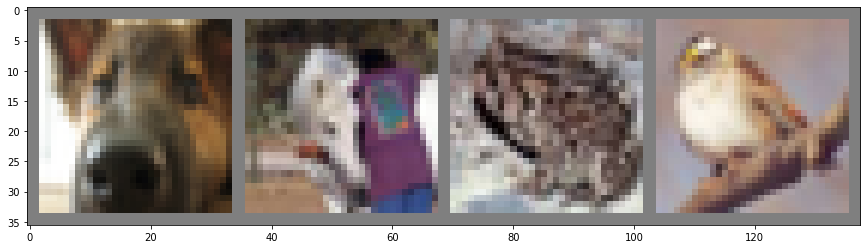

  dog horse  frog  bird


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    
    plt.figure(figsize=(16,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

batch = trainloader

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Теперь опишем класс сети. Будем использовать классическую сеть LeNet. Данная сеть была предложена в 1998 году и является одной из первых попыток разработки современного deep learning. 

Сеть имеет следующую архитектуру

![](https://miro.medium.com/max/3600/1*-NnRGtEsiLHfNnUCSXoa-Q.png)

Таким образом сеть имеет:
 * входной слой для изображений 32х32 ( в нашем случае 3х32х32),
 * два сверточных слоя, 
 * каждый сверточный слой имеет также макс-пулинг субдискретизацию,
 * слой векторизации карты признаков (приобразования матрицы в вектор путем ее "разворачивания",
 * два полносвязных внутренних слоя,
 * выходной слой - слой классификации с 10 выходами.

Также особенности архитектуры:
* свертка валидная (с уменьшением размера карты признаков на размер ядра - 1)$^*$;
* ядро свертки имеет размер 5х5 (размер ядра = 5);
* макс-пулин выполняется с шагом 2 по тайлам 2х2;
* первый сверточный слой выдает 6 карт признаков 14х14 (после макс-пулинга);
* второй сверточный слой выдает 16 карт признаков 5х5 (после макс-пулинга);
* слой разворачивания принимает 16 карт признаков 5х5 и выдет вектор $1х16*5*5$ (1х400);
* первый полносвязный слой имеет 120 выходов (120 перцептронов);
* второй полносвязный слой имеет на выходе 84 перцептрона.

$^*$Вобщем случае размер выхода свертки можно расчитать как: W=(W−F+2P)/S+1, where W is input size, F is kernel size, S is stride applied, and P is padding. 

**Реализуем сверточную сеть LeNet в виде класса, !Однако, для учебных целей добавим в сеть батч-нормализацию и дроп-ауты**

In [ ]:
class CNNModel(nn.Module):
    
    N_CLASSES = 10  
    
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # convolution
        self.conv1   = nn.Conv2d(in_channels  = 3, 
                                 out_channels = 6, 
                                 kernel_size  = 5)       

        self.conv2   = nn.Conv2d(in_channels  = 6, 
                                 out_channels = 16,
                                 kernel_size  = 5)
        
        self.bn  = nn.BatchNorm2d(16)  
        self.dropout = nn.Dropout(0.1)
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2, 
                                    stride      = 2)
        
        # classification
        self.fc1 = nn.Linear(in_features  = 16 * 5 * 5, 
                             out_features = 120)
        
        self.fc2 = nn.Linear(in_features  = 120, 
                             out_features = 84)
        
        self.fc_out = nn.Linear(in_features = 84, 
                                out_features = self.N_CLASSES)
    
    # specific operation
    def flatten(self, x):
        return x.view(-1, 16 * 5 * 5)
    
    def forward(self, x):
        
        # 1-st layer
        x = self.conv1(x)
        x = torch.relu(x)        
        x = self.maxpool(x)
        x = self.dropout(x)
        
        #2-nd layer
        x = self.conv2(x)         
        x = self.bn(x)        
        x = torch.relu(x)        
        x = self.maxpool(x)

        #flatten
        x = self.flatten(x)
        
        # 1-st fc layer
        x = self.fc1(x)
        x = torch.relu(x)
        
        # 2-nd fc layer
        x = self.fc2(x)
        x = torch.relu(x)
        
        # output layer
        x = self.fc_out(x)
        
        return x#torch.softmax(x, dim=1)

In [ ]:
print(images.shape)

torch.Size([4, 3, 32, 32])


**Опишим настрой**

In [ ]:
LR = 0.001
cnn_net   = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_net.parameters(), lr=LR)


Посмотрим структуру параметров созданной сети

In [ ]:
for name, param in cnn_net.named_parameters():
    print(name, '\t structure =',list(param.size()))

conv1.weight 	 structure = [6, 3, 5, 5]
conv1.bias 	 structure = [6]
conv2.weight 	 structure = [16, 6, 5, 5]
conv2.bias 	 structure = [16]
bn.weight 	 structure = [16]
bn.bias 	 structure = [16]
fc1.weight 	 structure = [120, 400]
fc1.bias 	 structure = [120]
fc2.weight 	 structure = [84, 120]
fc2.bias 	 structure = [84]
fc_out.weight 	 structure = [10, 84]
fc_out.bias 	 structure = [10]


In [ ]:
summary(cnn_net,input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
           Dropout-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
       BatchNorm2d-5           [-1, 16, 10, 10]              32
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 62,038
Trainable params: 62,038
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.24
Estimated Total Size (MB): 0.33
---------------------------------------------

**Процесс обучения**

In [ ]:
EPOHS = 5

for epoch in range(EPOHS):  # loop over the dataset multiple times
    cnn_net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize        
        outputs = cnn_net(inputs)        
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.894
[1,  4000] loss: 1.706
[1,  6000] loss: 1.613
[1,  8000] loss: 1.547
[1, 10000] loss: 1.502
[1, 12000] loss: 1.478
[2,  2000] loss: 1.432
[2,  4000] loss: 1.392
[2,  6000] loss: 1.385
[2,  8000] loss: 1.340
[2, 10000] loss: 1.351
[2, 12000] loss: 1.325
[3,  2000] loss: 1.281
[3,  4000] loss: 1.275
[3,  6000] loss: 1.289
[3,  8000] loss: 1.263
[3, 10000] loss: 1.246
[3, 12000] loss: 1.255
[4,  2000] loss: 1.217
[4,  4000] loss: 1.226
[4,  6000] loss: 1.201
[4,  8000] loss: 1.205
[4, 10000] loss: 1.205
[4, 12000] loss: 1.188
[5,  2000] loss: 1.143
[5,  4000] loss: 1.150
[5,  6000] loss: 1.161
[5,  8000] loss: 1.145
[5, 10000] loss: 1.166
[5, 12000] loss: 1.165
Finished Training


**Сохраним результат**

In [ ]:
PATH = './cifar_net.pth'
torch.save(cnn_net.state_dict(), PATH)

**Загрузим результат**

In [ ]:
cnn_net = CNNModel()
cnn_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

**Проверим результат на тесте**

In [ ]:
cnn_net.eval()
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = cnn_net(images)
print(outputs)

tensor([[-3.2837, -3.9673, -1.5299,  0.7314, -1.7745, -0.0486, -0.6104, -3.3757,
         -0.9014, -3.8526],
        [-0.2538,  3.5094, -5.6621, -6.5749, -7.8627, -6.9011, -7.5081, -8.6892,
          1.7389, -1.0329],
        [ 0.5637,  0.0210, -2.3020, -3.8727, -4.1313, -3.7516, -4.5720, -4.9599,
          1.0423, -1.8073],
        [ 1.0702, -1.3061, -2.3262, -4.3609, -3.3588, -4.0132, -5.9665, -3.8883,
          1.4958, -4.3026]], grad_fn=<AddmmBackward>)


**Приведем результат к более понятному виду**
Каждый номер в выходном тензоре будет класс соответствующий картинке батча

In [ ]:
_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([3, 1, 8, 8])


**Посмотрим, что получилось**

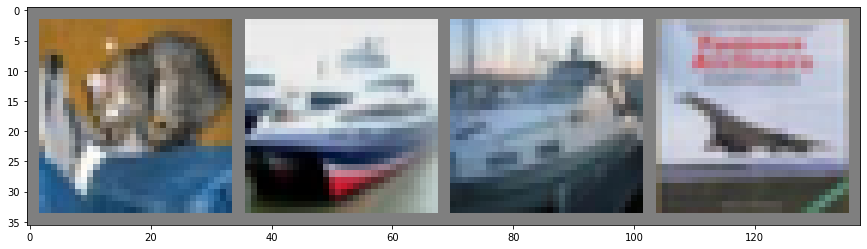

GroundTruth:    cat  ship  ship plane
Predicted :     cat   car  ship  ship


In [ ]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted :  ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

**Попробуем посчитать точность как число правильно классифицированных изобаржений к общему числу изображений**

In [ ]:
cnn_net.eval()
correct = 0
total   = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs        = cnn_net(images)
        _, predicted    = torch.max(outputs.data, 1)
        total   += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


**Проведем анализ по каждому классу**

In [ ]:
cnn_net.eval()
class_correct = list(0. for i in range(10))
class_total   = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 76 %
Accuracy of   car : 83 %
Accuracy of  bird : 52 %
Accuracy of   cat : 30 %
Accuracy of  deer : 49 %
Accuracy of   dog : 43 %
Accuracy of  frog : 67 %
Accuracy of horse : 70 %
Accuracy of  ship : 65 %
Accuracy of truck : 57 %


#### Упражнение 1 
Добавьте к процессу обучения валидацию и добавьте валидационный датасет.

#### Упражнение 2
Улучшьте архитектуру сети путем использования доп.слоев батч-нормализации, дроп-аутов, добавлением слоев и друхи техник.

#### Упражнение 3
Проанализируйте полученные результаты, уберите из обучающей выборки класс с наименьшей точностью, проведите повторное обучение.


- - -

## Оптимизация  обучения модели сверточной сети

**Инициализация весов модели**

In [ ]:
cnn_net = CNNModel()
        
def init_weights(m):
    # for differernt types of layers different initialization could be applied
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)
    
    #same as type(m) == nn.Conv2d, but more correct to use isinstance   
    if isinstance(m, nn.Conv2d):  
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)   

cnn_net.apply(init_weights);

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_net.parameters(), lr=0.001)

Проверим как прошла инициализация для значений смещений

In [ ]:
for name, p in cnn_net.named_parameters():    
    if 'bias' in name:
        print(p,'\n')

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True) 

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True) 

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True) 

Parameter containing:
tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.010

Также посмортим веса для одного из слоев

In [ ]:
print(cnn_net.fc2.weight)

Parameter containing:
tensor([[-0.0049,  0.1568, -0.1938,  ...,  0.0210,  0.2001,  0.0854],
        [ 0.2390,  0.1583,  0.1660,  ...,  0.2324, -0.1878, -0.0452],
        [-0.1908,  0.0208, -0.0475,  ..., -0.1081, -0.0418,  0.0394],
        ...,
        [-0.1874, -0.2636,  0.0752,  ...,  0.1175, -0.1062, -0.1552],
        [ 0.0119, -0.1899, -0.2029,  ...,  0.1675,  0.0606, -0.0726],
        [ 0.2841,  0.1060, -0.0233,  ..., -0.1134, -0.0474,  0.1394]],
       requires_grad=True)


**Регуляризаия**

используем эластическую регуляризацию для весов и для смещения.

In [ ]:
EPOHS = 5
lambda_l1 = 1e-5
lambda_l2 = 1e-3
for epoch in range(EPOHS):  # loop over the dataset multiple times
    cnn_net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize        
        outputs = cnn_net(inputs)        
        loss    = criterion(outputs, labels)
        
        l1_regularization = 0
        l2_regularization = 0
        
        for p in cnn_net.parameters():
            l1_regularization += torch.abs(p).sum()
            l2_regularization += torch.pow(p,2).sum()     

        loss += lambda_l1*l1_regularization + lambda_l2*l2_regularization
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


print('Finished Training')

[1,  2000] loss: 2.244
[1,  4000] loss: 1.931
[1,  6000] loss: 1.801
[1,  8000] loss: 1.731
[1, 10000] loss: 1.704
[1, 12000] loss: 1.662
[2,  2000] loss: 1.621
[2,  4000] loss: 1.619
[2,  6000] loss: 1.598
[2,  8000] loss: 1.592
[2, 10000] loss: 1.588


KeyboardInterrupt: 

посмотрим на результат


In [ ]:
cnn_net.eval()
class_correct = list(0. for i in range(10))
class_total   = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

#### Упрпажнение 1
Проведите инициализацию смещения слоя батч-нормализации нулями.


#### Упрпажнение 2
1. Исключите из регуляризации слой батч-нормализации.
2. Введите особую процедуру регуляризации для выходного слоя сети
<details>
<summary>Click here for hint</summary>
  Обратится к конкретному слою можно
```
    torch.norm(model.fc1.weight, p=1)
```

- - -

## Сегментационные модели сверточных сетей

В предыдущих примерах мы рассмотрели задачу классификации. Однако, это не едиственная задача, которую можно решать нейронными сетями.
В данном примере рассмотрим задачу семантической сегментации. 


В таких задачах требуется выделение каких-либо объектов в выходных данных (например, изображении) из входных данных (например, входного изображения).


Работу сети можно проиллюстрировать следующим образом.

![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSJqjFWfg48nnHgI8qERMXbsFvHPUuK7EIzSQ&usqp=CAU)

Задачу сематической сегментации рассмотрим для модели нейронной сети UNet.
Данная сеть, как и большинство сегментационных моделей, состоит из двух частей: энкодера и декодера.

Цель первой части (энкодера) - сжатие исходных данных в т.н. "набор карт латентных признаков". 

То есть, по существу, закодировать входную информацию с избыточностью так, чтобы потом можно было раскодировать только то, что нужно - задано выходной маской.

Цель второй части (декдера) - раскодирование набора латентных признаков так, чтобы остался выделенным только нужный объект.

Особенность сети UNet заключается в том, что при раскодировании используется не только информацию декодера, но и информация из энкода.
Это достигается за счет соединения слоев, получаемых в декодере непосредственно и аналогичных по размеру слоев энкодера.

Схема данной сети показана на рисунке ниже.

![](https://miro.medium.com/max/770/1*XvJffq5FAdDS4FoCqUb76g.png)


**Импорт основных библиотек**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.optim import lr_scheduler

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

In [ ]:
import time
import copy
import numpy as np
import random
import matplotlib.pyplot as plt

from PIL import Image

Создадим датасет - будем использовать готовый пример, взятый [тут](https://github.com/usuyama/pytorch-unet), однако не много измененный. 

Будем создавать изображения, на которых имеются разные геометрические фигуры.
Допустим, что из этих фигур нас интересует треугольник. Поэтому мы будем генерировать изображения с разными фигурами в качестве входных и выходное изображение (т.н. маску) в виде треугольника.


In [ ]:
# Owned here https://github.com/usuyama/pytorch-unet

def generate_random_data(height, width, count):
    x, y = zip(*[generate_img_and_mask(height, width) for i in range(0, count)])
    X = np.asarray(x) * 255
    X = X.transpose([0, 2, 3, 1]).astype(np.uint8)
    Y = np.asarray(y)
    return X, Y

def generate_img_and_mask(height, width):
    shape = (height, width)

    triangle_location = get_random_location(*shape, zoom = 2)
    circle_location1  = get_random_location(*shape, zoom=1)
    circle_location2  = get_random_location(*shape, zoom=0.7)
    mesh_location     = get_random_location(*shape, zoom=0.7)
    square_location   = get_random_location(*shape, zoom=0.4)
    plus_location     = get_random_location(*shape, zoom=1.2)

    # Create input image
    arr = np.zeros(shape, dtype=bool)
    arr = add_triangle(arr, *triangle_location)
    arr = add_circle(arr, *circle_location1)
    arr = add_circle(arr, *circle_location2, fill=True)
    arr = add_mesh_square(arr, *mesh_location)
    arr = add_filled_square(arr, *square_location)
    arr = add_plus(arr, *plus_location)
    arr = np.reshape(arr, (1, height, width)).astype(np.float32)

    # Create target masks
    masks = np.asarray([
        add_filled_square(np.zeros(shape, dtype=bool), *square_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location2, fill=True),
        add_triangle(np.zeros(shape, dtype=bool), *triangle_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location1),
        add_filled_square(np.zeros(shape, dtype=bool), *mesh_location),
        add_plus(np.zeros(shape, dtype=bool), *plus_location)]).astype(np.float32)

    return arr, masks

def add_square(arr, x, y, size):
    s = int(size / 2)
    arr[x-s,y-s:y+s] = True
    arr[x+s,y-s:y+s] = True
    arr[x-s:x+s,y-s] = True
    arr[x-s:x+s,y+s] = True
    return arr

def add_filled_square(arr, x, y, size):
    s = int(size / 2)
    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]
    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, yy > y - s, yy < y + s]))

def logical_and(arrays):
    new_array = np.ones(arrays[0].shape, dtype=bool)
    for a in arrays:
        new_array = np.logical_and(new_array, a)
    return new_array

def add_mesh_square(arr, x, y, size):
    s = int(size / 2)
    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]
    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, xx % 2 == 1, yy > y - s, yy < y + s, yy % 2 == 1]))

def add_triangle(arr, x, y, size):
    s = int(size / 2)
    triangle = np.tril(4*np.ones((size, size), dtype=bool))
    arr[x-s:x-s+triangle.shape[0],y-s:y-s+triangle.shape[1]] = triangle
    return arr

def add_circle(arr, x, y, size, fill=False):
    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]
    circle = np.sqrt((xx - x) ** 2 + (yy - y) ** 2)
    new_arr = np.logical_or(arr, np.logical_and(circle < size, circle >= size * 0.7 if not fill else True))
    return new_arr

def add_plus(arr, x, y, size):
    s = int(size / 2)
    arr[x-1:x+1,y-s:y+s] = True
    arr[x-s:x+s,y-1:y+1] = True
    return arr

def get_random_location(width, height, zoom=1.0):
    x = int(width * random.uniform(0.1, 0.9))
    y = int(height * random.uniform(0.1, 0.9))
    size = int(min(width, height) * random.uniform(0.06, 0.12) * zoom)
    return (x, y, size)

class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.input_images, self.target_masks = generate_random_data(32, 32, count=count)
        self.transform = transform

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask  = self.target_masks[idx]
        
        if self.transform:
            image = self.transform(image)

        return [image, mask[:][2:3]]

# use the same transformations for train/val in this example
trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [ 0.2])])

train_set = SimDataset(2000, transform = trans)
val_set  = SimDataset(200, transform = trans)

image_datasets = {'train': train_set, 'val': val_set}

batch_size = 8

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

**Посмотрим на один минибатч из датасета - входные изображения и маски**

torch.Size([8, 1, 32, 32])
torch.Size([8, 1, 32, 32])
torch.Size([8, 1, 32, 32])
torch.Size([8, 1, 32, 32])


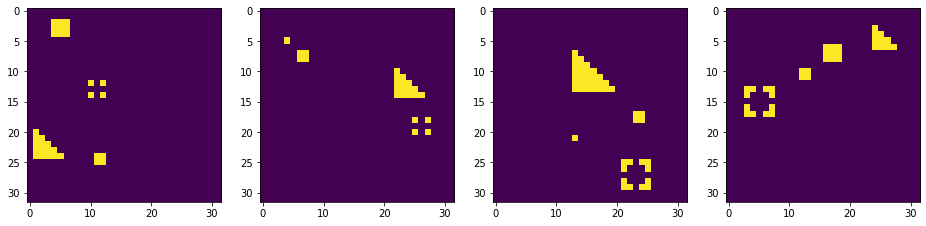

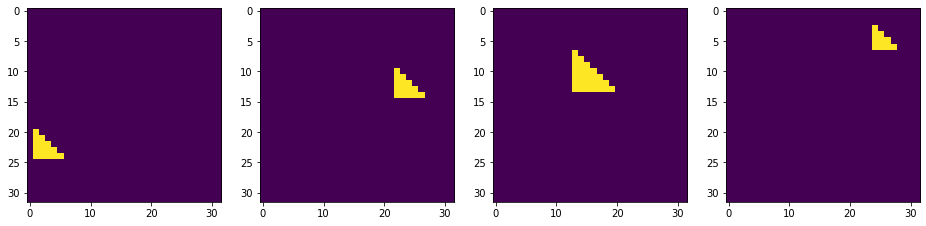

In [ ]:
images,masks = next(iter(dataloaders['train']))


print(images.shape)

print(images.shape)
print(masks.shape)

plt.figure(figsize=(16,4))
plt.subplot(141);plt.imshow(images[0][0])
plt.subplot(142);plt.imshow(images[1][0])
plt.subplot(143);plt.imshow(images[2][0])
plt.subplot(144);plt.imshow(images[3][0])

print(images.shape)
plt.figure(figsize=(16,4))
plt.subplot(141);plt.imshow(masks[0][0])
plt.subplot(142);plt.imshow(masks[1][0])
plt.subplot(143);plt.imshow(masks[2][0])
plt.subplot(144);plt.imshow(masks[3][0])

**Создадим класс нейронной сети**
* Сеть будет состоять из 4 блоков энкодера и 4 блоков декотора.
* Каждый блок будет состоять из двух операций свертки с ядром 3х3 и режмом same.
* В энкодере будем использовать макспулин (MaxPool2d).
* В декодере операцию, обратную макспулингу - (Upsample) методом билинейного преобразования.
* Выберем "одинарный" размер (число) карт признаков как SIZE = 32.

In [ ]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels,  out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   

SIZE = 32

class UNet(nn.Module):

    def __init__(self, n_class=1):
        super().__init__()
                
        self.down1 = conv_block(1,      SIZE)
        self.down2 = conv_block(SIZE,   SIZE*2)
        self.down3 = conv_block(SIZE*2, SIZE*4)
        self.down4 = conv_block(SIZE*4, SIZE*8)        

        self.maxpool  = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, 
                                    mode='bilinear', 
                                    align_corners=True)        
        
        self.up3 = conv_block(SIZE*4 + SIZE*8, SIZE*4)
        self.up2 = conv_block(SIZE*2 + SIZE*4, SIZE*2)
        self.up1 = conv_block(SIZE*2 + SIZE,   SIZE)
        
        self.out = nn.Conv2d(SIZE, n_class, 1)
        
        
    def forward(self, x):
        
        #ENCODER
        conv1 = self.down1(x)
        x = self.maxpool(conv1)

        conv2 = self.down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.down3(x)
        x = self.maxpool(conv3)   
        
        x = self.down4(x)
        
        #DECODER
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.up1(x)
        
        out = self.out(x)
        
        return out

**Создадим экземпляр нейронной сети**

In [ ]:
unet_model = UNet()
summary(unet_model, input_size=(1, 32, 32),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           9,248
              ReLU-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,928
              ReLU-9           [-1, 64, 16, 16]               0
        MaxPool2d-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 8, 8]          73,856
             ReLU-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 128, 8, 8]         147,584
             ReLU-14            [-1, 12

**Обучение будем проводить по двум вариантам функции потерь: бинарная энтропия и т.н. DICE**

Dice (Коэффициент Серенса-Дайса) представляет собой метрику, характерную для сегментации - по существу, отношение удвоенной площади пересечения искомого объекта (макси) к сумме площадей искомого объекта и полученного по результатам работы нейронной сети.

![](https://miro.medium.com/max/858/1*yUd5ckecHjWZf6hGrdlwzA.png)

Если говорить более качественно, то Dice говорит о том, на сколько правильно объект выделен по площади и по его расположению относительно искомого.
Иллюстрация плохого, среднего и хорошего DICE приведена на картинке ниже


![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Intersection_over_Union_-_poor%2C_good_and_excellent_score.png/300px-Intersection_over_Union_-_poor%2C_good_and_excellent_score.png)

Расстояние, соответствующиее Dice расчитчвается как:

$$dice = 1 - \frac {2\cdot(A\cap B)}{|A|+|B|}$$

где $A,B$ - это площади полученного и искомого объектов, знак $\cap$ - это обозначение пересечения площадей


In [ ]:
def dice_loss(pred, target, smooth = 1.):
    pred   = pred.contiguous()
    target = target.contiguous()    
    
    intersection   = (pred * target).sum(dim=2).sum(dim=2)
    sum_of_squares = pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2)
    
    loss = 1 - 2. * intersection / sum_of_squares 
    
    return loss.mean()

Таким образом у нас будет две метрики DICE и BCE, а также функция потерь.
Будем считать функцию потерь как комбинацию DICE и BCE с рзными весами. 

Таким образом в функции потерь будет учитываться место объекта и его площадь (DICE), а также особенности формы объекта с точки зрения его параметров, например яркости или особенностей формы (например широховатости краев) (BCE).

In [ ]:
METRICS_DEFAULT = {'bce':0.0,'dice':0.0,'loss':0.0}

Объеденим расчет метрик и потерь в одну функцию

In [ ]:
def calc_loss(pred, target, metrics = None, bce_weight=0.5):
    
    if (metrics is None):
        metrics = METRICS_DEFAULT.copy()

    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)    
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce']  += bce.data.cpu().numpy()
    metrics['dice'] += dice.data.cpu().numpy() 
    metrics['loss'] += loss.data.cpu().numpy() 

    return loss, metrics


**Опишем процедуру тренировки как отдельную функцию**

Процедура включает следующие параметры:
* модель нейронной сети (unet_model);
* словарь двух загрузчиков данных в формате DataLoader (dataloaders) 
    (для валидации 'valid'; для тренировки 'train');
* функцию оптимизатор (optimizer);
* функцуию изменения сокрости обучения (scheduler);
* число эпох (num_epochs).

Выход процедуры - обученная модель.

**Особенности процедуры train_model**:
* Процедура включает как фазу тренировку, так и фазу валидацию для каждой эпохи.
* Каждый раз, когда после обучения эпохи значения метрик ниже чем были до этого, 
    то результат тренировки записывается.
* В итоге возвращается результат на лучшей эпохе.
* В процессе каждой эпохи на экран выводится служебная информация.


In [ ]:
def train_model(unet_model, dataloaders, optimizer,  scheduler=None, num_epochs=25):
    
    #INITIALIZATION OF THE BEST MODEL INITAL STATE
    best_model = copy.deepcopy(unet_model.state_dict())
    best_loss  = 1e10
    best_epoch = 0
    
    
    start_time = time.time()
    
    #EPOHS OF TRAINING
    for epoch in range(num_epochs):
        
        #SERVICE INFORMATION 
        print('-' * 10)
        since = time.time()        
        print('Epoch {}/{}'.format(epoch+1, num_epochs),end=' ')
        for param_group in optimizer.param_groups: print("LR", param_group['lr'])  

        #TRAINING AND VALIDATION PHASES
        for phase in ['train', 'val']:
            
            #FOR SUCH LAYERS AS DROPOUT AND BATCH NORM
            if phase == 'train':               
                unet_model.train()  # Set model to training mode
            else:
                unet_model.eval()   # Set model to evaluate mode
         
            #COUNTER FOR SAMPLES PROCESSED IN THE EPOCH
            epoch_samples = 0  
            
            #RESET METRICS VALUES FOR EPOCH
            metrics       = METRICS_DEFAULT.copy()
            
            #MINI_BATCHES
            for inputs, labels in dataloaders[phase]:
                optimizer.zero_grad()
                
                #IF VAL, THEN NO_GRAD, ELSE GRAD_ENABLE
                with torch.set_grad_enabled(phase == 'train'):                  
                    outputs       = unet_model.forward(inputs)                    
                    loss, metrics = calc_loss(outputs, labels, metrics)                    
                    
                    if phase == 'train':                        
                        loss.backward()                        
                        optimizer.step()

                #FOR LOSS NORMALIZATION
                epoch_samples += inputs.size(0)
            
            #CHECK FOR THE BEST RESULT            
            epoch_loss = metrics['loss'] / epoch_samples            
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss  = epoch_loss
                best_epoch = epoch
                best_model = copy.deepcopy(unet_model.state_dict())
            
            #LEARNING RATE SCHADULER
            if phase == 'train' and scheduler is not None:
                scheduler.step()                
            
            #SERVICE INFORMATION 
            print(str(phase),":",
                  'loss:%.5f'%(metrics['loss']),
                  'dice:%.5f'%(1-metrics['dice']), #1-DICE IS BETTER TO INTERPRITATE
                  'bce:%.5f' %(metrics['bce']))       
        
        #SERVICE INFORMATION 
        time_elapsed = time.time() - since
        print('Epoch time: {:.0f}m {:.0f}s'.\
              format(time_elapsed // 60, time_elapsed % 60))
    
    #SERVICE INFORMATION 
    print('Best val loss: {:4f}'.format(best_loss), 
          'best epoch: %d'%(best_epoch),
          'training_time:{:.0f}m {:.0f}s'.\
              format((time.time()-start_time) // 60, 
                     (time.time()-start_time) % 60))

    #LOAD THE BEST MODEL STATE (WEIGHTS AND BIASES)
    unet_model.load_state_dict(best_model)
    return unet_model

**Зададим особенности обучения.** 
* Оптимизатор Adam;
* каждые 10 эпох будем снижать скорость обучения с коэффициентом 0.9;
* Сделаем возможность выбирать или использовать предобученная модель или инциализировать новую.
     То есть сделаем возможность дообучать модели.

In [ ]:
EPOCH = 20
pretrained = True

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(unet_model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.9)

if pretrained == False: #IF NEW MODEL
    unet_model = UNet()

**тренировка сети**

In [ ]:
unet_model =\
    train_model(unet_model, 
                dataloaders = dataloaders,
                optimizer   = optimizer_ft, 
                scheduler   = exp_lr_scheduler,  
                num_epochs  = EPOCH)    

----------
Epoch 1/20 LR 0.0001
train : loss:88.99715 dice:-149.26764 bce:27.72667
saving best model
val : loss:3.41808 dice:-5.21179 bce:0.62436
Epoch time: 0m 52s
----------
Epoch 2/20 LR 0.0001
train : loss:23.89559 dice:-43.06356 bce:3.72762
saving best model
val : loss:0.92763 dice:-0.75036 bce:0.10490
Epoch time: 0m 51s
----------
Epoch 3/20 LR 0.0001
train : loss:5.87469 dice:-10.03694 bce:0.71244
saving best model
val : loss:0.45363 dice:0.17031 bce:0.07757
Epoch time: 0m 53s
----------
Epoch 4/20 LR 0.0001
train : loss:3.62841 dice:-5.71953 bce:0.53730
val : loss:0.60130 dice:-0.11752 bce:0.08509
Epoch time: 0m 52s
----------
Epoch 5/20 LR 0.0001
train : loss:2.92768 dice:-4.38651 bce:0.46885
saving best model
val : loss:0.37150 dice:0.31172 bce:0.05472
Epoch time: 0m 51s
----------
Epoch 6/20 LR 0.0001
train : loss:2.52196 dice:-3.62078 bce:0.42314
saving best model
val : loss:0.29215 dice:0.45851 bce:0.04282
Epoch time: 0m 51s
----------
Epoch 7/20 LR 0.0001
train : loss:2.2

**Создадим тестовый дата-сет**

In [ ]:
test_dataset = SimDataset(4, transform = trans)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

**Посмотрим на метрики на тестовом датасете**

In [ ]:
unet_model.eval() 
inputs, labels = next(iter(test_loader))
predicts       = unet_model(inputs)
loss, metrics  = calc_loss(predicts, labels)
print('loss:%.5f'%(metrics['loss']),
                  'dice:%.5f'%(1-metrics['dice']), 
                  'bce:%.5f' %(metrics['bce']))

loss:0.00043 dice:0.99918 bce:0.00005


**Проверим результат визуально**

 I N P U T 


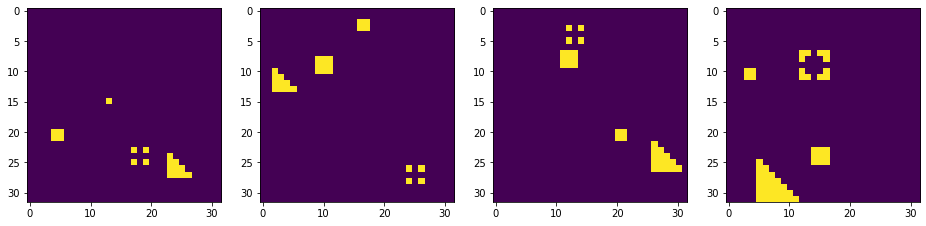

 G R O U N D T R U T H 


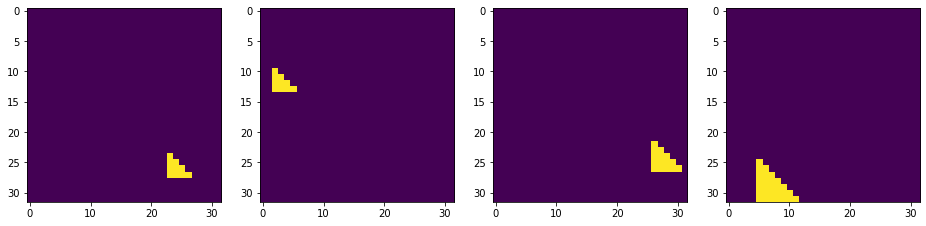

 P R E D I C T E D 


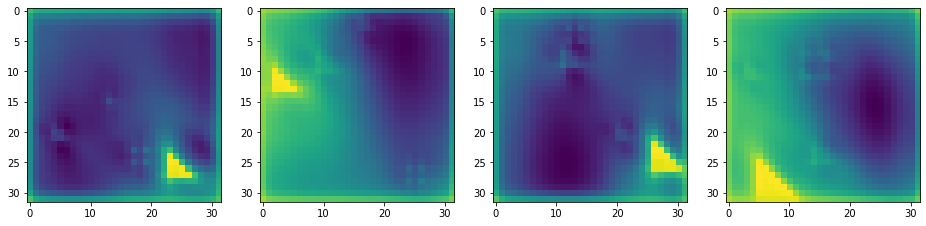

In [ ]:
predicts = predicts.data.cpu().numpy()

print(' I N P U T ')
plt.figure(figsize=(16,4))
plt.subplot(141);plt.imshow(inputs[0][0])
plt.subplot(142);plt.imshow(inputs[1][0])
plt.subplot(143);plt.imshow(inputs[2][0])
plt.subplot(144);plt.imshow(inputs[3][0])
plt.show()

print(' G R O U N D T R U T H ')
plt.figure(figsize=(16,4))
plt.subplot(141);plt.imshow(labels[0].sum(0))
plt.subplot(142);plt.imshow(labels[1].sum(0))
plt.subplot(143);plt.imshow(labels[2].sum(0))
plt.subplot(144);plt.imshow(labels[3].sum(0))
plt.show()

print(' P R E D I C T E D ')
plt.figure(figsize=(16,4))
plt.subplot(141);plt.imshow(predicts[0][0])
plt.subplot(142);plt.imshow(predicts[1][0])
plt.subplot(143);plt.imshow(predicts[2][0])
plt.subplot(144);plt.imshow(predicts[3][0])
plt.show()


#### Упражнение 1
Сохраните веса модели в отдельный файл.

Дообучите модель (без ее сброса - перезагрузки) на 10 эпохах

#### Упражнение 2
Добавьте возможность вывода графика функции потерь и метрики DICE по результатам обучения.

#### Упражнение 3
Добавьте в процесс обучения метику Jaccard
![](https://neo4j.com/docs/graph-algorithms/current/images/jaccard.png)

#### Упражнение 4
Добавьте к процессу обучения функцию ранней остановки (остановки по неизменению или росту валидации)

#### Упражнение 5
Добавьте к архитектуре сети батч-нормализаци, дроп-ауты, а также добавьте инициализацию весов, для случая, если это не дообучение

#### Упражнение 6

Уберите из архитектуры UNet связи энкодера и декодера - то есть преобразуйте UNet в SegNet. 
Сравните качество обучения сети.

- - - 

## Предобучение сверточной сети автоэнкодером

Часто при обучении модели сети - для поднятия качества ее обучения, особенно для небольших датасетов желательным является предобучение нейронной сети.
Такое предобучение может быть произведено или на каком-то близком, но большом датасете или, например, методом автоэнкодера (такой подход? по существу, представляет собой концепцию сетей глубокого доверия - deep belief network). В случае UNet подход глубокого доверия может быть произведен путем обучения нейронной сети для случая, когда ее выход должен повторять ее вход - по сути это обучение без учителя. Стоит отметить, что преобучение и обучение могут быть проведены с разными видами функции потерь или другими параметрами обучения.


**Этап автоэнкодера**

Выбирем в качестве функции потерь MSE (Minimum Square Error)

In [ ]:
AUTOMETRICS_DEFAULT = {'mse':0.0,'dice':0.0,'loss':0.0}

**Пересоздадим модель**

In [ ]:
unet_model = UNet()

**Пусть функция потерь будет только MSE**

In [ ]:
def calc_autoloss(pred, inputs, metrics = None, mce_weight=1):
    
    if (metrics is None):
        metrics = AUTOMETRICS_DEFAULT.copy()

    mse = F.mse_loss(pred, inputs)
        
    pred = torch.sigmoid(pred)    
    dice = dice_loss(pred, inputs)
    
    loss = mse #* mce_weight + dice * (1 - mce_weight)
    
    metrics['mse']  += mse.data.cpu().numpy()
    metrics['dice'] += dice.data.cpu().numpy() 
    metrics['loss'] += loss.data.cpu().numpy() 

    return loss, metrics

**Перепишем процедуру обучения сети**

In [ ]:
def train_autoencoder(unet_model, dataloaders, optimizer,  scheduler=None, num_epochs=25):
    
    #INITIALIZATION OF THE BEST MODEL INITAL STATE
    best_model = copy.deepcopy(unet_model.state_dict())
    best_loss  = 1e10
    best_epoch = 0
    
    start_time = time.time()
    
    
    #EPOHS OF TRAINING
    for epoch in range(num_epochs):
        
        #SERVICE INFORMATION 
        print('-' * 10)
        since = time.time()        
        print('Epoch {}/{}'.format(epoch+1, num_epochs),end=' ')
        for param_group in optimizer.param_groups: print("LR", param_group['lr'])  

        #TRAINING AND VALIDATION PHASES
        for phase in ['train', 'val']:
            
            #FOR SUCH LAYERS AS DROPOUT  AND BATCH NORM
            if phase == 'train':               
                unet_model.train()  
            else:
                unet_model.eval()  
         
            #COUNTER FOR SAMPLES PROCESSED IN THE EPOCH
            epoch_samples = 0  
            
            #RESET METRICS VALUES FOR EPOCH
            metrics       = AUTOMETRICS_DEFAULT.copy()
            
            #MINI_BATCHES
            for inputs, labels in dataloaders[phase]:
                optimizer.zero_grad()
                
                #IF VAL, THEN NO_GRAD, ELSE GRAD_ENABLE
                with torch.set_grad_enabled(phase == 'train'):                  
                    outputs       = unet_model.forward(inputs)                    
                    loss, metrics = calc_autoloss(outputs, inputs, metrics)                    
                    
                    if phase == 'train':                        
                        loss.backward()                        
                        optimizer.step()
                        
                #FOR LOSS NORMALIZATION ON THE BATCH SIZE
                epoch_samples += inputs.size(0)
            
            #CHECK FOR THE BEST RESULT            
            epoch_loss = metrics['loss'] / epoch_samples            
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss  = epoch_loss
                best_epoch = epoch
                best_model = copy.deepcopy(unet_model.state_dict())
            
            #LEARNING RATE SCHADULER
            if phase == 'train' and scheduler is not None:
                scheduler.step()                
            
            #SERVICE INFORMATION 
            print(str(phase),":",
                  'loss:%.5f'%(metrics['loss']),
                  'dice:%.5f'%(1-metrics['dice']), #1-DICE IS BETTER TO INTERPRITATE
                  'mse:%.5f' %(metrics['mse']))       
        
        #SERVICE INFORMATION
        time_elapsed = time.time() - since
        print('Epoch time: {:.0f}m {:.0f}s'.\
              format(time_elapsed // 60, time_elapsed % 60))
    
    #SERVICE INFORMATION 
    print('Best val loss: {:4f}'.format(best_loss), 
          'best epoch: %d'%(best_epoch),
          'training_time:{:.0f}m {:.0f}s'.\
              format((time.time()-start_time) // 60, 
                     (time.time()-start_time) % 60))

    #LOAD THE BEST MODEL STATE (WEIGHTS AND BIASES)
    unet_model.load_state_dict(best_model)
    return unet_model

**Параметры обучения**

In [ ]:
EPOCH = 20
pretrained = True

# Observe that all parameters are being optimized
optimizer_ft     = optim.Adam(unet_model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.9)

if pretrained == False:
    unet_model = UNet()

**Тренировка автоэнкодера**

In [ ]:
unet_model =\
    train_autoencoder(unet_model, 
                      dataloaders = dataloaders,
                      optimizer   = optimizer_ft, 
                      scheduler   = exp_lr_scheduler,  
                      num_epochs  = EPOCH)    

----------
Epoch 1/20 LR 0.0001
train : loss:6883.09349 dice:-222.18551 mse:6883.09349
saving best model
val : loss:3.59113 dice:-21.36611 mse:3.59113
Epoch time: 0m 51s
----------
Epoch 2/20 LR 0.0001
train : loss:21.05984 dice:-223.37881 mse:21.05984
saving best model
val : loss:1.06789 dice:-21.71218 mse:1.06789
Epoch time: 0m 52s
----------
Epoch 3/20 LR 0.0001
train : loss:8.54663 dice:-224.59898 mse:8.54663
saving best model
val : loss:0.70344 dice:-21.56215 mse:0.70344
Epoch time: 0m 52s
----------
Epoch 4/20 LR 0.0001
train : loss:6.50161 dice:-224.79586 mse:6.50161
saving best model
val : loss:0.57155 dice:-21.61425 mse:0.57155
Epoch time: 0m 53s
----------
Epoch 5/20 LR 0.0001
train : loss:5.35930 dice:-224.93129 mse:5.35930
saving best model
val : loss:0.48960 dice:-21.69812 mse:0.48960
Epoch time: 0m 54s
----------
Epoch 6/20 LR 0.0001
train : loss:4.46581 dice:-225.03906 mse:4.46581
saving best model
val : loss:0.41641 dice:-21.51201 mse:0.41641
Epoch time: 0m 54s
--------

**Посмотрим результат для тестового датасета, созданного ранее**

$^*$ Если тестовый датасет не найден, пресоздайте его

loss:0.00181 dice:0.09802 mse:0.00181
 I N P U T  = G R O U N D T R U T H 


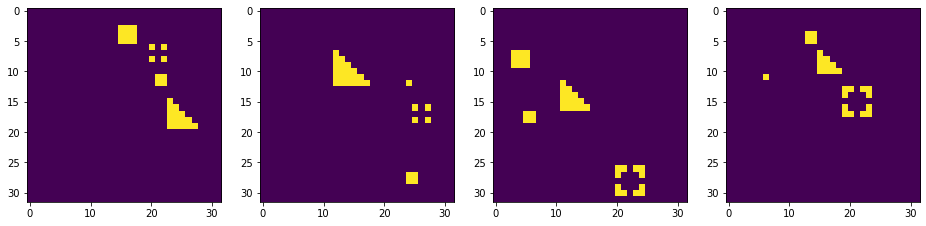

 P R E D I C T E D 


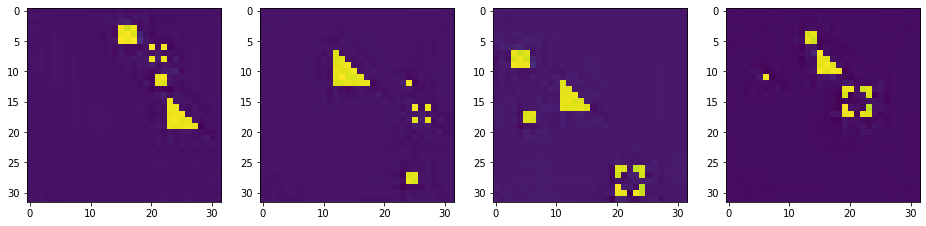

In [ ]:
unet_model.eval() 
inputs, labels = next(iter(test_loader))
predicts       = unet_model(inputs)
loss, metrics  = calc_autoloss(predicts, inputs)
print('loss:%.5f'%(metrics['loss']),
                  'dice:%.5f'%(1-metrics['dice']), 
                  'mse:%.5f' %(metrics['mse']))

predicts = predicts.data.cpu().numpy()

print(' I N P U T  =   G R O U N D T R U T H ')
plt.figure(figsize=(16,4))
plt.subplot(141);plt.imshow(inputs[0][0])
plt.subplot(142);plt.imshow(inputs[1][0])
plt.subplot(143);plt.imshow(inputs[2][0])
plt.subplot(144);plt.imshow(inputs[3][0])
plt.show()

print(' P R E D I C T E D ')
plt.figure(figsize=(16,4))
plt.subplot(141);plt.imshow(predicts[0][0])
plt.subplot(142);plt.imshow(predicts[1][0])
plt.subplot(143);plt.imshow(predicts[2][0])
plt.subplot(144);plt.imshow(predicts[3][0])
plt.show()

**Попробуем обучить предобученную сеть**

In [ ]:
unet_model =\
    train_model(unet_model, 
                dataloaders = dataloaders,
                optimizer   = optimizer_ft, 
                scheduler   = exp_lr_scheduler,  
                num_epochs  = EPOCH)   

----------
Epoch 0/19 LR 8.1e-05
train : loss:9.51207 dice:-16.98738 bce:1.03676
saving best model
val : loss:0.38224 dice:0.26683 bce:0.03131
Epoch time: 0m 50s
----------
Epoch 1/19 LR 8.1e-05
train : loss:2.64964 dice:-4.07184 bce:0.22745
saving best model
val : loss:0.32173 dice:0.38086 bce:0.02432
Epoch time: 0m 55s
----------
Epoch 2/19 LR 8.1e-05
train : loss:2.25833 dice:-3.30974 bce:0.20691
saving best model
val : loss:0.23639 dice:0.54585 bce:0.01863
Epoch time: 0m 51s
----------
Epoch 3/19 LR 8.1e-05
train : loss:1.79976 dice:-2.42105 bce:0.17846
saving best model
val : loss:0.15528 dice:0.70261 bce:0.01317
Epoch time: 0m 54s
----------
Epoch 4/19 LR 8.1e-05
train : loss:1.44232 dice:-1.74357 bce:0.14107
val : loss:0.20354 dice:0.61138 bce:0.01845
Epoch time: 1m 2s
----------
Epoch 5/19 LR 8.1e-05
train : loss:1.16712 dice:-1.22211 bce:0.11212
saving best model
val : loss:0.10726 dice:0.79581 bce:0.01032
Epoch time: 0m 52s
----------
Epoch 6/19 LR 8.1e-05
train : loss:1.0404

loss:0.00000 dice:0.99999 bce:0.00000
 I N P U T  = G R O U N D T R U T H 


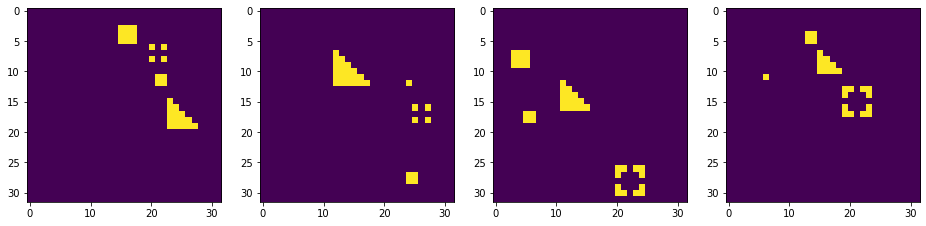

 P R E D I C T E D 


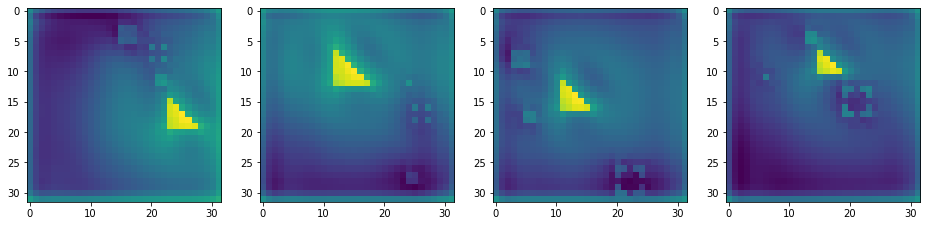

In [ ]:
unet_model.eval() 
inputs, labels = next(iter(test_loader))
predicts       = unet_model(inputs)
loss, metrics  = calc_loss(predicts, labels)
print('loss:%.5f'%(metrics['loss']),
                  'dice:%.5f'%(1-metrics['dice']), 
                  'bce:%.5f' %(metrics['bce']))

predicts = predicts.data.cpu().numpy()

print(' I N P U T  = G R O U N D T R U T H ')
plt.figure(figsize=(16,4))
plt.subplot(141);plt.imshow(inputs[0][0])
plt.subplot(142);plt.imshow(inputs[1][0])
plt.subplot(143);plt.imshow(inputs[2][0])
plt.subplot(144);plt.imshow(inputs[3][0])
plt.show()

print(' P R E D I C T E D ')
plt.figure(figsize=(16,4))
plt.subplot(141);plt.imshow(predicts[0][0])
plt.subplot(142);plt.imshow(predicts[1][0])
plt.subplot(143);plt.imshow(predicts[2][0])
plt.subplot(144);plt.imshow(predicts[3][0])
plt.show()

#### Упражнение 1
Сравните результат работы предобученной сети и сети с произвольной инициализацией параметров.
Для этого загрузите и тот и другой в разные модели и проведите оценку функции потерь, метрик качества, а также проведите визуальное сравнение.


#### Упражнение 2

На самом деле процедура тренировки автоэнкодера без учителя не требует процедуры валидации.
Перепишите процедуру тренировки автоэнкодра так, чтобы исключить из нее валидацию.